In [86]:
import pandas as pd
import numpy as np
from datetime import timedelta
from glob import glob
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

pd.options.plotting.backend = 'plotly'

## plotly.io를 import 한 후 renderers 기본값을 꼭 "notebook_connected" 로 설정
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [43]:
path = 'solar/'
files = sorted(glob(path+'*.csv'))

site_info = pd.read_csv(files[4]) # 발전소 정보
energy = pd.read_csv(files[2]) # 발전소별 발전량

dangjin_fcst = pd.read_csv(files[0]) # 당진 예보 데이터
dangjin_obs = pd.read_csv(files[1]) # 당진 기상 관측 자료

ulsan_fcst = pd.read_csv(files[5]) # 울산 예보 데이터
ulsan_obs = pd.read_csv(files[6]) # 울산 기상 관측 자료

sample_submission = pd.read_csv(files[3]) # 제출 양식

#### 발전소 정보 : 각 발전소의 발전용량(MW), 위치, 설치각, 입사각, 위도, 경도

In [47]:
site_info.head()

,Id,Capacity,Address,InstallationAngle,IncidentAngle,Latitude,Longitude
0,당진수상태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
1,당진자재창고태양광,0.7,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
2,당진태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
3,울산태양광,0.5,울산광역시 남구 용잠로 623,20.0,20.0,35.477651,129.380778


#### 발전소별 발전량 : 2018-03-01 ~ 2021-01-31까지 1시간 단위로 기록된<br>각 발전소별 발전량

In [13]:
energy.head(10)
# time : 1시간 단위 계량된 시간 (ex-2018-03-01 1:00:00 => 
                                # 2018-03-01 00:00:00 ~ 2018-03-01 1:00:00 1시간동안 발전량 계량)
# 당진이 더 많이 발전

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0
5,2018-03-01 6:00:00,0.0,0.0,0,0
6,2018-03-01 7:00:00,0.0,0.0,0,0
7,2018-03-01 8:00:00,0.0,0.0,0,4
8,2018-03-01 9:00:00,36.0,33.0,37,35
9,2018-03-01 10:00:00,313.0,209.0,318,71


In [11]:
energy.info()
# 'dangjin_floating(당진수상태양광)', 'dangjin_warehouse(당진자재창고태양광)' 결측치 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               25632 non-null  object 
 1   dangjin_floating   25608 non-null  float64
 2   dangjin_warehouse  25584 non-null  float64
 3   dangjin            25632 non-null  int64  
 4   ulsan              25632 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1001.4+ KB


In [15]:
energy.isnull().sum()

time                  0
dangjin_floating     24
dangjin_warehouse    48
dangjin               0
ulsan                 0
dtype: int64

In [14]:
energy.describe()

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
count,25608.000000,25584.000000,25632.000000,25632.000000
mean,122.056311,92.476665,139.653285,64.159761
std,192.041585,146.423366,220.491387,101.020447
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,191.000000,145.000000,227.000000,101.000000
max,753.000000,593.000000,867.000000,392.000000


#### 새벽 0시가 24:00:00으로 표기되어 datetime형으로 바뀌지 않는 사항 조정

In [57]:
# changing time 24 -> 00
def convert_24_to_00(dt):
    dt = [i for i in dt]
    dt_join = ''.join(dt)
    if dt_join[11:13] == '24': ##만약 시간이 24면
        dt[11:13] = ['0','0']
        # changing day
        if not(dt_join[5:10] in ['01-31','02-29','03-31','04-30','05-31','06-30','07-31','08-31','09-30','10-31','11-30','12-31']):##월말이 아니면
            if len(str(int(dt_join[8:10]) + 1)) == 2:
                dt[8:10] = [i for i in str(int(dt_join[8:10]) + 1)]
            else:
                dt[8:10] = [i for i in '0'+str(int(dt_join[8:10]) + 1)]
        else: ##만약 시간이 24이고 월말이면
            dt[8:10] = ['0','1']
            #changing month
            if dt_join[5:7] != '12':##시간이 24이고 월말이지만 연말이 아니면
                if len(str(int(dt_join[5:7])+1)) == 2:
                    dt[5:7] = [i for i in str(int(dt_join[5:7])+1)]
                else:
                    dt[5:7] = [i for i in '0'+str(int(dt_join[5:7])+1)]
            else:##시간이 24이고 월말이고 연말이면
                dt[5:7] = ['0','1']
                dt[0:4] = [i for i in str(int(dt_join[0:4])+1)]
    if int(dt_join[0:4]) % 4 != 0 and dt_join[5:10] == '02-28':
        dt[5:7] = ['0','3']
        dt[8:10] = ['0','1']
        
    return ''.join(dt)

energy['time'] = energy['time'].apply(lambda x: convert_24_to_00(x))
energy['time'] = pd.to_datetime(energy['time'])

In [58]:
energy['hour'] = energy['time'].dt.hour
energy['date'] = energy['time'].dt.date

#발전소 별 하루 동안의 모든 발전량이 0으로 기입된 날짜  -> 기입 오류로 판단
dangjin_floating = energy.groupby('date')['dangjin_floating'].sum()
zero_dangjin_floating = dangjin_floating[dangjin_floating == 0].index
dangjin_warehouse = energy.groupby('date')['dangjin_warehouse'].sum()
zero_dangjin_warehouse = dangjin_warehouse[dangjin_warehouse == 0].index
dangjin = energy.groupby('date')['dangjin'].sum()
zero_dangjin = dangjin[dangjin == 0].index
ulsan = energy.groupby('date')['ulsan'].sum()
zero_ulsan = ulsan[ulsan == 0].index

print(zero_dangjin_floating)
print(zero_dangjin_warehouse)
print(zero_dangjin)
print(zero_ulsan)

Index([2019-02-28, 2019-03-02, 2019-09-07, 2019-09-08, 2019-10-03, 2020-06-20,
       2020-06-21, 2020-06-22, 2020-06-23, 2020-06-24, 2020-06-25, 2020-06-26,
       2021-02-01],
      dtype='object', name='date')
Index([2018-03-14, 2018-03-15, 2018-03-16, 2018-03-17, 2018-03-18, 2018-03-19,
       2018-03-20, 2018-03-21, 2018-03-22, 2018-03-23, 2018-03-24, 2018-03-25,
       2018-03-26, 2018-03-27, 2018-03-28, 2019-02-28, 2019-03-02, 2019-09-07,
       2019-09-08, 2019-10-03, 2020-08-03, 2020-08-04, 2021-02-01],
      dtype='object', name='date')
Index([2019-02-28, 2019-09-07, 2019-09-08, 2019-09-09, 2019-10-03, 2020-01-07,
       2020-08-03, 2020-09-07, 2021-02-01],
      dtype='object', name='date')
Index([2018-12-22, 2018-12-23, 2019-02-28, 2019-09-07, 2019-09-08, 2019-09-21,
       2019-09-22, 2019-10-03, 2020-05-26, 2020-05-27, 2020-09-03, 2020-09-04,
       2020-09-05, 2020-09-06, 2020-09-07, 2021-02-01],
      dtype='object', name='date')


In [59]:
# 1일 종합 energy가 0으로 기록된 날짜(어느 발전호 하나라도 0이면 모두 포함)
zero_idx = np.array(list(set(zero_dangjin_floating)|set(zero_dangjin_warehouse)|set(zero_dangjin)|set(zero_ulsan)))

In [60]:
#위 날짜에 해당하는 발전량은 모두 0으로 기록 -> 오류로 판단, drop

#Filling missing values
print('date of missing values in dangjin_floating')
print(energy[energy.dangjin_floating.isnull()])
print('date of missing values in dangjin_warehouse')
print(energy[energy.dangjin_warehouse.isnull()])

dangjin_floating_null_idx = energy[energy.dangjin_floating.isnull()].index
dangjin_warehouse_null_idx = energy[energy.dangjin_warehouse.isnull()].index

date of missing values in dangjin_floating
                     time  dangjin_floating  dangjin_warehouse  dangjin  \
20352 2020-06-26 01:00:00               NaN                0.0        0   
20353 2020-06-26 02:00:00               NaN                0.0        0   
20354 2020-06-26 03:00:00               NaN                0.0        0   
20355 2020-06-26 04:00:00               NaN                0.0        0   
20356 2020-06-26 05:00:00               NaN                0.0        0   
20357 2020-06-26 06:00:00               NaN                0.0        0   
20358 2020-06-26 07:00:00               NaN                7.0        2   
20359 2020-06-26 08:00:00               NaN               20.0       18   
20360 2020-06-26 09:00:00               NaN              148.0      175   
20361 2020-06-26 10:00:00               NaN              242.0      330   
20362 2020-06-26 11:00:00               NaN              371.0      534   
20363 2020-06-26 12:00:00               NaN              

In [61]:
#발전량이 null인 부분도 drop

#cross validation을 위해 4개의 발전소별 index를 통일
energy_cv = energy[~energy['date'].isin(zero_idx)].drop(['date', 'hour'], axis = 1)
energy_cv.dropna(axis = 0, inplace = True)

In [62]:
# full training을 위해 4개의 발전소별로 target variable생성
dangjin_energy = energy[~energy['date'].isin(zero_dangjin)][['time','dangjin']]
floating_energy = energy[~energy['date'].isin(zero_dangjin_floating)][['time','dangjin_floating']]
warehouse_energy = energy[~energy['date'].isin(zero_dangjin_warehouse)][['time','dangjin_warehouse']]
ulsan_energy = energy[~energy['date'].isin(zero_ulsan)][['time','ulsan']]

<AxesSubplot:xlabel='time', ylabel='ulsan'>

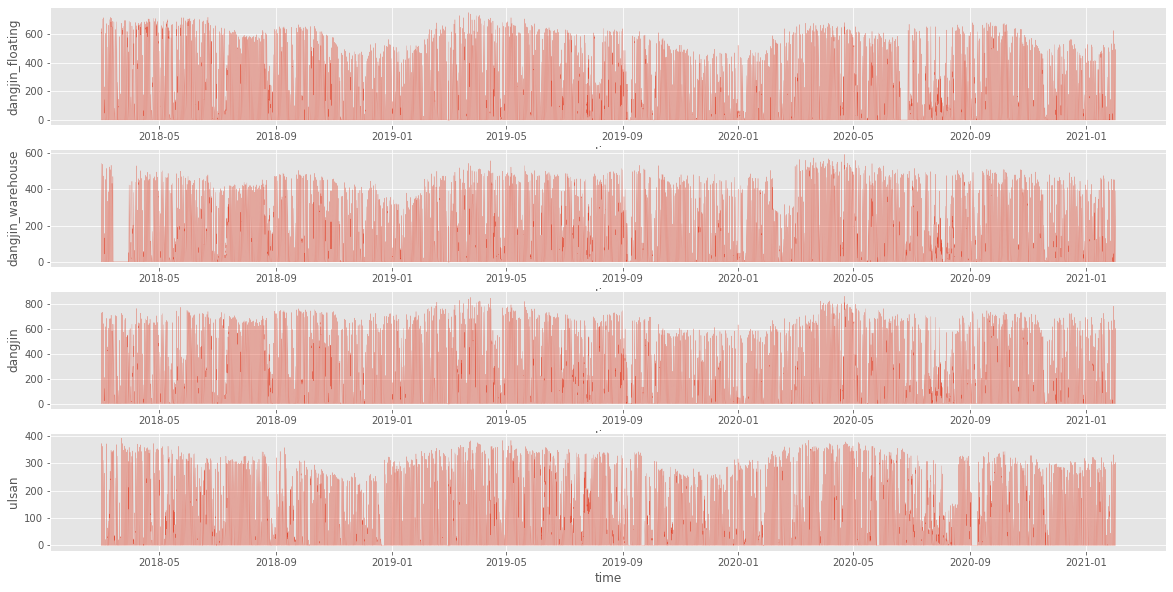

In [87]:
# 전체 시계열 분포 확인
fig = plt.figure(figsize = (20, 10))
plt.subplot(411)
sns.lineplot(data=energy, x= 'time', y = 'dangjin_floating', linewidth = 0.2)
plt.subplot(412)
sns.lineplot(data=energy, x= 'time', y = 'dangjin_warehouse', linewidth = 0.2)
plt.subplot(413)
sns.lineplot(data=energy, x= 'time', y = 'dangjin', linewidth = 0.2)
plt.subplot(414)
sns.lineplot(data=energy, x= 'time', y = 'ulsan', linewidth = 0.2)

#### 처음 일주일간 발전량 시각화

In [17]:
fig = px.line(energy[:24*7], x='time', y=['dangjin_floating','dangjin_warehouse','dangjin','ulsan'])
fig.show()
# 3월 4일경 발전량이 낮은 이유는 날씨의 영향? -> 확인 결과 전국 흐렸고 밤늦게 비 옴
# 당진 수상태양광발전의 경우 수상태양광발전이기 때문에 수면 위 냉각효과로 육상에 설치한 것보다 
# 효율이 10% 더 좋을 수 있음. 

#### 시각화 위해 time column을 month와 hour로 나눔

In [18]:
energy['month'] = energy['time'].dt.month
energy['hour'] = energy['time'].dt.hour

#### 월별 발전량

In [19]:
mean_month = energy.groupby('month').mean()
fig = px.bar(mean_month, x=mean_month.index, y=['dangjin_floating','dangjin_warehouse','dangjin','ulsan'])
fig.show()
# 일반적으로 해가 가장 높게뜨고 기온이 높은 여름(6월~8월)에 발전량이 가장 많을 것 같지만 
# 평균적으론 봄(3월~5월)이 발전량이 더 높음. 이는 태양광판넬의 입사각이 20~30도라는 점, 
# 여름에 강수량이 많다는 점에서 이해 가능

#### 시간별 발전량

In [20]:
mean_hour = energy.groupby('hour').mean()
fig = px.bar(mean_hour, x=mean_hour.index, y=['dangjin_floating','dangjin_warehouse','dangjin','ulsan'])
fig.show()
# 20시부터 06시까지는 발전량 없음(해당 시간 0으로 초기화?), 오후 1~2시가 발전량 가장 높음

#### 발전량 0을 제외한 발전소별 발전량 분포

In [21]:
cols = ['dangjin_floating','dangjin_warehouse','dangjin','ulsan']
fig = px.box(energy[energy[cols]!=0], x=cols)
fig.update_traces(quartilemethod="exclusive")
fig.show()
# 평균적으로 100~200 사이 구간 발전량이 많음

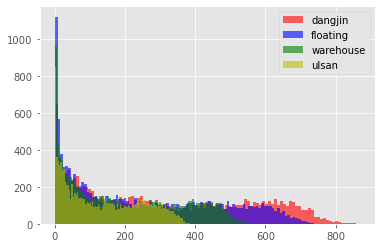

In [88]:
# 발전소 별 발전량 분포(histogram)
plt.hist(energy.loc[energy['dangjin']>0, 'dangjin'], alpha = 0.6, bins = 100, color = 'r', label = 'dangjin')
plt.hist(energy.loc[energy['dangjin_floating']>0, 'dangjin_floating'], alpha = 0.6, bins = 100, color = 'b', label = 'floating')
plt.hist(energy.loc[energy['dangjin_warehouse']>0, 'dangjin_warehouse'], alpha = 0.6, bins = 100, color = 'g', label = 'warehouse')
plt.hist(energy.loc[energy['ulsan']>0, 'ulsan'], alpha = 0.6, bins = 100, color = 'y', label = 'ulsan')
plt.legend()
# dangjin > floating > warehouse > ulsan 순으로 많음

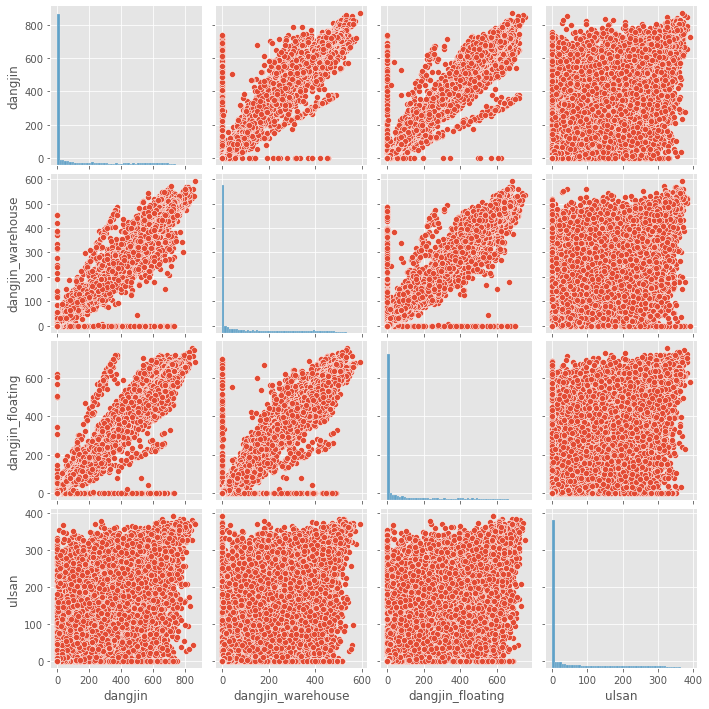

In [89]:
# 지역 별 발전량 비교
sns.pairplot(energy[['dangjin','dangjin_warehouse', 'dangjin_floating', 'ulsan']])
# 당진 내 지역의 태양광 발전량은 선형적 관계
# 울산 지역과 당진 지역의 태양광 발전량은 무관한 것으로 보임

<AxesSubplot:xlabel='time', ylabel='dangjin'>

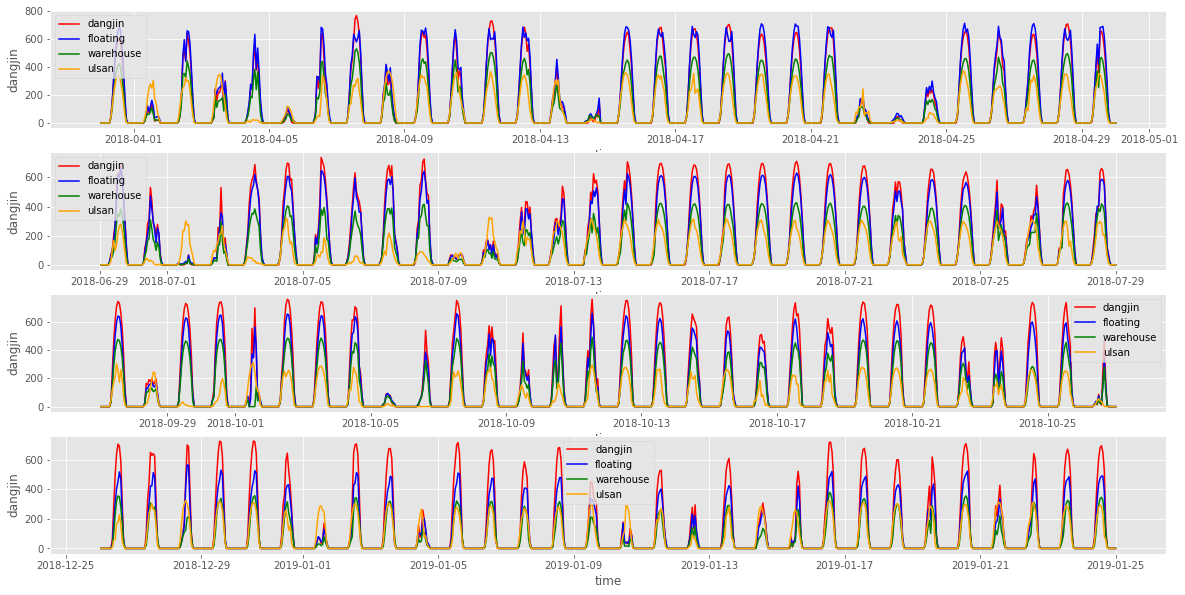

In [90]:
# 발전량 시계열
fig = plt.figure(figsize = (20,10))
df = energy[30*24:60*24]
plt.subplot(411)
sns.lineplot(data = df, x = 'time', y = 'dangjin', color = 'red', label = 'dangjin')
sns.lineplot(data = df, x = 'time', y = 'dangjin_floating', color = 'blue', label = 'floating')
sns.lineplot(data = df, x = 'time', y = 'dangjin_warehouse', color = 'green', label = 'warehouse')
sns.lineplot(data = df, x = 'time', y = 'ulsan', color = 'orange', label = 'ulsan')

df = energy[120*24:150*24]
plt.subplot(412)
sns.lineplot(data = df, x = 'time', y = 'dangjin', color = 'red', label = 'dangjin')
sns.lineplot(data = df, x = 'time', y = 'dangjin_floating', color = 'blue', label = 'floating')
sns.lineplot(data = df, x = 'time', y = 'dangjin_warehouse', color = 'green', label = 'warehouse')
sns.lineplot(data = df, x = 'time', y = 'ulsan', color = 'orange', label = 'ulsan')

df = energy[210*24:240*24]
plt.subplot(413)
sns.lineplot(data = df, x = 'time', y = 'dangjin', color = 'red', label = 'dangjin')
sns.lineplot(data = df, x = 'time', y = 'dangjin_floating', color = 'blue', label = 'floating')
sns.lineplot(data = df, x = 'time', y = 'dangjin_warehouse', color = 'green', label = 'warehouse')
sns.lineplot(data = df, x = 'time', y = 'ulsan', color = 'orange', label = 'ulsan')

df = energy[300*24:330*24]
plt.subplot(414)
sns.lineplot(data = df, x = 'time', y = 'dangjin', color = 'red', label = 'dangjin')
sns.lineplot(data = df, x = 'time', y = 'dangjin_floating', color = 'blue', label = 'floating')
sns.lineplot(data = df, x = 'time', y = 'dangjin_warehouse', color = 'green', label = 'warehouse')
sns.lineplot(data = df, x = 'time', y = 'ulsan', color = 'orange', label = 'ulsan')

#### 당진 기상관측자료 살펴보기

In [67]:
dangjin_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25632 entries, 0 to 25625
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               25632 non-null  datetime64[ns]
 1   Temperature_obs    25626 non-null  float64       
 2   WindSpeed_obs      25626 non-null  float64       
 3   WindDirection_obs  25626 non-null  float64       
 4   Humidity_obs       25626 non-null  float64       
 5   Cloud_obs          25626 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.4 MB


In [49]:
dangjin_obs.isnull().sum()
# 전운량 : 맑은 날이라고 가정, 0으로 채우기
# 기온, 풍속, 풍향, 습도 : 바로 앞 시간대의 관측량으로 대체

지점              0
지점명             0
일시              0
기온(°C)         37
풍속(m/s)        36
풍향(16방위)       36
습도(%)          35
전운량(10분위)    3970
dtype: int64

In [63]:
# Rename and# drop unnecessary feature
dangjin_obs.drop(['지점', '지점명'], axis = 1, inplace = True)
ulsan_obs.drop(['지점', '지점명'], axis = 1, inplace = True)

dangjin_obs.columns = ['time', 'Temperature_obs', 'WindSpeed_obs', 'WindDirection_obs', 'Humidity_obs', 'Cloud_obs']
ulsan_obs.columns = ['time', 'Temperature_obs', 'WindSpeed_obs', 'WindDirection_obs', 'Humidity_obs', 'Cloud_obs']

dangjin_obs['time'] = pd.to_datetime(dangjin_obs['time'])
ulsan_obs['time'] = pd.to_datetime(ulsan_obs['time'])

In [64]:
# 6개의 관측치가 데이터 상에 존재하지 않음(nrow = 25626) -> 결측지점 파악 후 np.nan으로 채워야 함
a = dangjin_obs.reset_index()
a = ulsan_obs.merge(a, on = 'time', how = 'left')
a.loc[a['index'].isnull(), 'time']

3491   2018-07-24 11:00:00
3492   2018-07-24 12:00:00
3493   2018-07-24 13:00:00
3494   2018-07-24 14:00:00
3495   2018-07-24 15:00:00
3496   2018-07-24 16:00:00
Name: time, dtype: datetime64[ns]

In [65]:
# 해당 위치에 행을 추가 후, np.nan으로 imputing
dangjin_obs_1 = dangjin_obs[dangjin_obs['time'] < pd.to_datetime('2018-07-24 11:00:00')]
dangjin_obs_2 = dangjin_obs[dangjin_obs['time'] > pd.to_datetime('2018-07-24 16:00:00')]
dangjin_obs_3 = pd.DataFrame({'time':['2018-07-24 11:00:00', '2018-07-24 12:00:00', '2018-07-24 13:00:00', '2018-07-24 14:00:00','2018-07-24 15:00:00','2018-07-24 16:00:00'],
              'Temperature_obs':[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
              'WindSpeed_obs':[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
              'WindDirection_obs':[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
              'Humidity_obs':[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
              'Cloud_obs':[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]})
dangjin_obs_3['time'] = pd.to_datetime(dangjin_obs_3['time'])

dangjin_obs = pd.concat([dangjin_obs_1, dangjin_obs_3, dangjin_obs_2], axis = 0)

#### 당진) 발전량-날씨 상관관계

In [27]:
dangjin.corr()

,dangjin_floating,dangjin_warehouse,dangjin,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
dangjin_floating,1.000000,0.961408,0.974142,0.307088,0.438443,0.344152,-0.632884,-0.188188
dangjin_warehouse,0.961408,1.000000,0.972938,0.311508,0.426527,0.339161,-0.637108,-0.168499
dangjin,0.974142,0.972938,1.000000,0.294323,0.435736,0.348794,-0.644704,-0.185427
기온(°C),0.307088,0.311508,0.294323,1.000000,0.168179,0.128834,-0.000126,0.037965
풍속(m/s),0.438443,0.426527,0.435736,0.168179,1.000000,0.534637,-0.416005,0.006391
풍향(16방위),0.344152,0.339161,0.348794,0.128834,0.534637,1.000000,-0.371380,-0.004386
습도(%),-0.632884,-0.637108,-0.644704,-0.000126,-0.416005,-0.371380,1.000000,0.176116
전운량(10분위),-0.188188,-0.168499,-0.185427,0.037965,0.006391,-0.004386,0.176116,1.000000


In [28]:
fig = px.imshow(dangjin.corr())
fig.show()
# 기온은 0.3, 풍속은 0.43, 풍향은 0.4 정도의 양의 상관관계를 보이고 있으며, 
# 습도 -0.63, 전운량 -0.18 정도의 음의 상관관계를 보임
# 절댓값으로만 보자면 습도가 가장 상관관계가 뚜렷

#### * 태양광 발전기 효율 관련 요소
    광원 세기 높을수록(당연)
    온도 낮을수록 효율이 좋을 수 있음
    습도 높을수록 효율 저해 (전지판 표면 물방울 응결)

#### 당진 기상관측자료 살펴보기

In [29]:
ulsan_obs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         25632 non-null  int64  
 1   지점명        25632 non-null  object 
 2   일시         25632 non-null  object 
 3   기온(°C)     25628 non-null  float64
 4   풍속(m/s)    25631 non-null  float64
 5   풍향(16방위)   25631 non-null  float64
 6   습도(%)      25631 non-null  float64
 7   전운량(10분위)  24807 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [30]:
ulsan_obs_data.isnull().sum()
# 당진보다는 결측치 적음, 같은 방식으로 전처리 진행

지점             0
지점명            0
일시             0
기온(°C)         4
풍속(m/s)        1
풍향(16방위)       1
습도(%)          1
전운량(10분위)    825
dtype: int64

In [31]:
ulsan_obs_data = weather_preprocessing(ulsan_obs_data)

#### 울산) 발전량-날씨 상관관계

In [32]:
df_joined = pd.merge(energy, ulsan_obs_data, left_on='time', right_on='일시', how='inner')
cols = ['time','ulsan', '기온(°C)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '전운량(10분위)']
ulsan = df_joined[cols]

In [33]:
ulsan.corr()

,ulsan,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
ulsan,1.000000,0.240879,0.307515,-0.186768,-0.447506,-0.190440
기온(°C),0.240879,1.000000,-0.070631,-0.293445,0.355624,0.203843
풍속(m/s),0.307515,-0.070631,1.000000,0.172195,-0.300215,-0.014533
풍향(16방위),-0.186768,-0.293445,0.172195,1.000000,-0.097894,-0.057273
습도(%),-0.447506,0.355624,-0.300215,-0.097894,1.000000,0.448958
전운량(10분위),-0.190440,0.203843,-0.014533,-0.057273,0.448958,1.000000


In [34]:
fig = px.imshow(ulsan.corr())
fig.show()
# 당진과 다르게(0.4) 풍향에서 음의 상관관계를 보임(-0.18)
# 상관계수의 절댓값이 그리 크지 않아 유의미하다고는 보기 힘듦

In [74]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.333333,85.000000,6.3,31.666667,4.0
26300,2021-03-01 20:00:00,5.666667,85.000000,6.1,29.333333,4.0
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0
26302,2021-03-01 22:00:00,5.000000,85.000000,5.9,27.000000,4.0


In [73]:
dangjin_fcst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Forecast_time  26304 non-null  object 
 1   Temperature    26304 non-null  float64
 2   Humidity       26304 non-null  float64
 3   WindSpeed      26304 non-null  float64
 4   WindDirection  26304 non-null  float64
 5   Cloud          26304 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.2+ MB


In [42]:
dangjin_fcst.describe()

,Temperature,Humidity,WindSpeed,WindDirection,Cloud
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000
mean,12.538473,77.159215,3.661466,214.169480,2.441378
std,9.799976,16.988980,2.628710,102.637370,1.181148
min,-14.000000,15.000000,0.000000,0.000000,1.000000
25%,4.333333,65.000000,1.900000,122.333333,1.000000
50%,13.000000,80.000000,2.800000,232.000000,2.666667
75%,21.000000,91.666667,4.600000,309.333333,3.666667
max,35.000000,100.000000,28.900000,360.000000,4.000000


In [84]:
# 당진) 상관도가 높다고 판단되는 온도, 습도, 풍속의 분포 확인
fig = px.line(dangjin_fcst[:24*7], x="Forecast_time", y=['Temperature', 'Humidity', 'WindSpeed'])
fig.show()

In [85]:
# 울산) 상관도가 높다고 판단되는 온도, 습도, 풍속의 분포 확인
fig = px.line(ulsan_fcst[:24*7], x="Forecast_time", y=['Temperature', 'Humidity', 'WindSpeed'])
fig.show()